In [1]:
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import ML_library        as MLL
import sys
import torch
import json
import os

sys.path.append('../../UPC')
import Database.DB_library as DBL
import MP.MP_library       as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
data_folder = '/home/claudio/cibran/Work/UPC/MP/Loaded_real_phonons'
compounds = os.listdir(data_folder)
idxs = np.arange(len(compounds))
np.random.shuffle(idxs)

Ti = 200
Tf = 1700
dT = 50

temperatures = np.arange(Ti, Tf+dT, dT)

input_folder  = '/home/claudio/cibran/Work/UPC/MP/models'
target_folder = f'{input_folder}/Fv-accurate-fulldata'
model_name    = f'{target_folder}/model.pt'

dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'

dropout = 0.4

# Load the data from the JSON file
with open(dataset_parameters_name_std, 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert torch tensors to numpy arrays
dataset_parameters = {}
for key, value in numpy_dict.items():
    try:
        dataset_parameters[key] = torch.tensor(value)
    except:
        dataset_parameters[key] = value
        
# Load Graph Neural Network model (making room for temperature as node attribute)
model = MLL.GCNN(features_channels=4+1, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))
model.eval()

/tmp/ipykernel_8639/2000373628.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))


GCNN(
  (conv1): GraphConv(5, 512)
  (conv2): GraphConv(512, 512)
  (linconv1): Linear(in_features=512, out_features=64, bias=True)
  (linconv2): Linear(in_features=64, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
#full_dataset = []
#full_labels  = []

target_mean = dataset_parameters['target_mean']
scale       = dataset_parameters['scale']
target_std  = dataset_parameters['target_std']

ground_truth = []
prediction   = []
for idx in idxs[:20]:
    try:
        compound = compounds[idx]
        path_to_PHONON = f'{data_folder}/{compound}'
        
        # ---
        # PHONON
        # ---
        
        # Loading number of atoms
        _, composition, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
        n_atoms = np.sum(concentration)
        
        # Reading supercell information
        dim_info = MPL.read_phonopyconf(path_to_PHONON)
        
        # Write mesh.conf file (needed for phonopy)
        MPL.write_meshconf(path_to_PHONON, compound, dim_info, Ti, Tf, dT)
        
        # Getting thermal properties with phonopy (ignoring output)
        previous_dir = os.getcwd()
        os.chdir(path_to_PHONON)
        os.system('phonopy -t mesh.conf > /dev/null')
        os.chdir(previous_dir)
        
        # Read generated thermal properties (kJ/mol)
        try:
            _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
        except FileNotFoundError:  # Some calculation not finished
            sys.exit('PHONON calculation not finished.')
        
        # Pass kJ / mol to meV / atom
        conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
        Fv_PHONON        /= conversion_factor
    
        # ---
        # ML
        # ---
        
        # Create dataset for predictions
        dataset, labels = MLL.create_predictions_dataset(path_to_PHONON, path_to_material=True, path_to_polymorph=True)

        # Standardize properties
        dataset = MLL.standarize_dataset(dataset, dataset_parameters, transformation=dataset_parameters['transformation'])
        
        # Include temperatures
        pred_dataset = MLL.include_temperatures(dataset, temperatures, dataset_parameters)
        
        #for i in range(len(pred_dataset)):
        #    Fv = torch.tensor([Fv_PHONON[i]], dtype=torch.float) * target_std / scale + target_mean
        #    pred_dataset[i].y = Fv
        
        #full_dataset.append(pred_dataset)
        
        #full_labels.append([f'{"".join(composition)} {compound}']*len(temperatures))
        
        # Compute predictions
        predictions = MLL.make_predictions(pred_dataset, model, dataset_parameters)
        
        # Computing the coefficients
        coefficients, metrics = MLL.compute_coefficients(temperatures, predictions)
        
        # Compute Fv
        Fv_pred = MLL.compute_Fv(temperatures, coefficients)
    
        # ---
        # Print results
        # ---
        
        FP  = Fv_PHONON
        FM  = Fv_pred[0]
        raw = predictions
        
        ground_truth.append(FP)
        prediction.append(FM)

        plt.plot(temperatures, FP, label='FP')
        plt.plot(temperatures, FM, label='FM')        
            
        plt.xlabel(r'$T$ (K)')
        plt.ylabel(r'$F_v$ (meV/atom)')
        plt.legend(loc='best')
        plt.show()
    except:
        pass

dataset = [item for sublist in full_dataset for item in sublist]
labels  = [item for sublist in full_labels for item in sublist]

print(len(dataset), len(labels))

torch.save(dataset, 'standardized_dataset.pt')
torch.save(labels,  'standardized_labels.pt')

# Some specific validation examples

In [3]:
reference_dataset = torch.load(f'{target_folder}/standardized_dataset.pt')

/tmp/ipykernel_8639/99321927.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reference_dataset = torch.load(f'{target_folder}/standardized_dataset.pt')


/tmp/ipykernel_8639/1669691340.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))


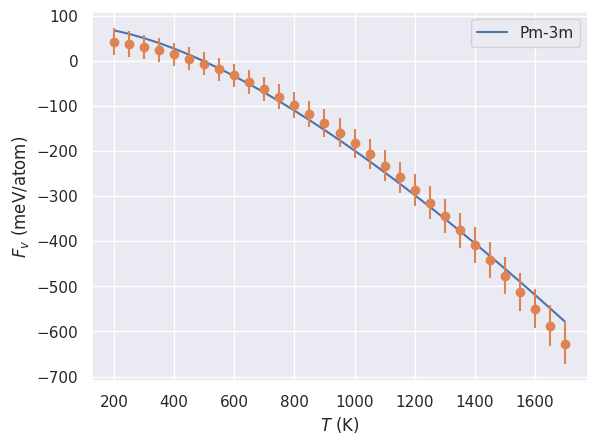

In [7]:
colors = ['b', 'r', 'g', 'k']

materials = {
    'BH6N': ['Cmc2_1', 'Pmn2_1'],
    'CaBH42': ['Fddd', 'I-42d'],
    'Li2FeCoO4': ['C2-c', 'R-3m'],
    'NaH': ['Fm-3m', 'Pm-3m'],
    'NaHO': ['P4-nmm', 'R3m'],
    'RbCuTe': ['P6_3-mmc', 'P6_3-mmc_2'],
    'RbAgSe': ['Cmcm', 'P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'MgS': ['F-43m', 'Fm-3m', 'P6_3-mmc'],
    'BaCl2': ['I4-mmm', 'P-62m'],
    'NaZnP': ['P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'RbScO2': ['P6_3-mmc', 'R-3m'],
    'CsYO2': ['P6_3-mmc', 'R-3m', 'R-3m_2'],
    'MgF2': ['P2_1-c', 'P-3m1', 'Pnnm', 'R-3m']
}

offsets = {
    'BH6N': 4522.343993936683,
    'CaBH42': 4144.65534897643,
    'Li2FeCoO4': 6516.480859677684,
    'NaH': 2403.016851739045,
    'NaHO': 4592.32568074285,
    'RbCuTe': 3509.4943688973763,
    'RbAgSe': 3368.582337527254,
    'MgS': 4428.2409955455005,
    'BaCl2': 4597.253871079191,
    'NaZnP': 3318.473003078988,
    'RbScO2': 7213.586284609213,
    'CsYO2': 7243.982865534706,
    'MgF2': 5273.468082416714
}

material = 'NaH'

polymorph = 'Pm-3m'

path_to_EPA    = f'/home/claudio/Desktop/validation-phonons/{material}/{polymorph}'
path_to_POSCAR = f'{path_to_EPA}'
path_to_PHONON = f'{path_to_EPA}'


# PHONON

# Loading number of atoms
_, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
n_atoms = np.sum(concentration)

# Reading supercell information
dim_info = MPL.read_phonopyconf(path_to_PHONON)

# Write mesh.conf file (needed for phonopy)
MPL.write_meshconf(path_to_PHONON, material, dim_info, Ti, Tf, dT)

# Getting thermal properties with phonopy (ignoring output)
previous_dir = os.getcwd()
os.chdir(path_to_PHONON)
os.system('phonopy -t mesh.conf > /dev/null')
os.chdir(previous_dir)

# Read generated thermal properties (kJ/mol)
try:
    _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
except FileNotFoundError:  # Some calculation not finished
    sys.exit('PHONON calculation not finished.')

# Pass kJ / molmp-1009220 to meV / atom
conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
Fv_PHONON        /= conversion_factor


# ML-IAP

Fv_ML_IAP = None
try:
    # Compare ML-IAP results

    # Compute vibrational (phonon) density of states
    if not os.path.exists(f'{path_to_EPA}/VDOS.dat'):
        DBL.get_VACF_VDOS(path_to_EPA)

    Fv_temp = []
    for temperature in temperatures:
        # ML-IAP
        Fv_temp.append(DBL.get_vibrational_properties(path_to_EPA, temperature)[0][4])

    # Append the result of the polymorf to the ML-IAP list
    Fv_ML_IAP = np.array(Fv_temp)
except:
    pass


# ML


# Create dataset for predictions
dataset, labels = MLL.create_predictions_dataset(path_to_POSCAR, path_to_material=True, path_to_polymorph=True)

# Santadirize properties
dataset = MLL.standarize_dataset(dataset, dataset_parameters, transformation=dataset_parameters['transformation'])

# Load Graph Neural Network model (making room for temperature as node attribute)
model = MLL.GCNN(features_channels=dataset[0].num_node_features+1, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))
model.eval()

# Include temperatures
pred_dataset = MLL.include_temperatures(dataset, temperatures, dataset_parameters)

# Compute predictions
predictions, uncertainties = MLL.make_predictions(reference_dataset, pred_dataset, model, dataset_parameters)

# Computing the coefficients
coefficients, metrics = MLL.compute_coefficients(temperatures, predictions, uncertainties)

# Compute Fv
Fv_pred = MLL.compute_Fv(temperatures, coefficients)


# Plotting

FP  = Fv_PHONON
FM  = Fv_pred[0]
raw = predictions

plt.plot(temperatures,     FP, label=f'{polymorph}')
plt.errorbar(temperatures, FM, yerr=uncertainties, fmt='o')

plt.xlabel(r'$T$ (K)')
plt.ylabel(r'$F_v$ (meV/atom)')
plt.legend(loc='best')
plt.show()

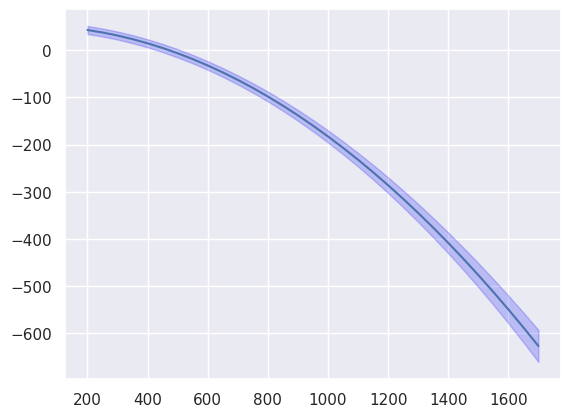

In [9]:
# Fit parameters and uncertainties
alpha, beta, gamma = coefficients[0][0], coefficients[1][0]*1e-5, coefficients[2][0]*1e-10
sigma_alpha, sigma_beta, sigma_gamma = metrics[0][0], metrics[1][0]*1e-5, metrics[2][0]*1e-10

# Define the function
def Helmholtz_free_energy_function(x, alpha, beta, gamma):
    return alpha + beta * x**2 + gamma * x**4

# Define uncertainty propagation
def uncertainty_band(x, sigma_alpha, sigma_beta, sigma_gamma):
    partial_alpha = 1
    partial_beta = x**2
    partial_gamma = x**4
    return np.sqrt(
        (partial_alpha * sigma_alpha)**2 +
        (partial_beta * sigma_beta)**2 +
        (partial_gamma * sigma_gamma)**2
    )

# Generate x-values and compute y-values
x = temperatures
y = Helmholtz_free_energy_function(x, alpha, beta, gamma)
y_err = uncertainty_band(x, sigma_alpha, sigma_beta, sigma_gamma)

# Plot the curve with uncertainty bands
plt.plot(x, y, label='Fitted Curve')
plt.fill_between(x, y - y_err, y + y_err, color='blue', alpha=0.2, label='Uncertainty Band')
plt.show()

/tmp/ipykernel_8367/1669691340.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))


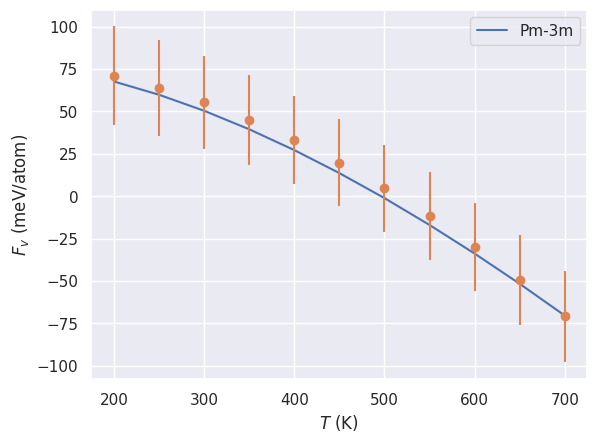

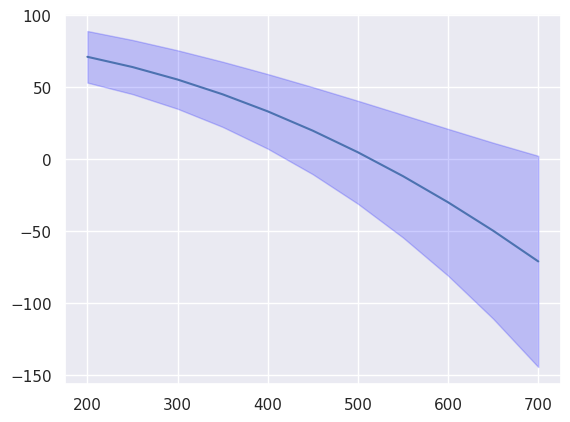

In [ ]:
colors = ['b', 'r', 'g', 'k']

materials = {
    'BH6N': ['Cmc2_1', 'Pmn2_1'],
    'CaBH42': ['Fddd', 'I-42d'],
    'Li2FeCoO4': ['C2-c', 'R-3m'],
    'NaH': ['Fm-3m', 'Pm-3m'],
    'NaHO': ['P4-nmm', 'R3m'],
    'RbCuTe': ['P6_3-mmc', 'P6_3-mmc_2'],
    'RbAgSe': ['Cmcm', 'P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'MgS': ['F-43m', 'Fm-3m', 'P6_3-mmc'],
    'BaCl2': ['I4-mmm', 'P-62m'],
    'NaZnP': ['P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'RbScO2': ['P6_3-mmc', 'R-3m'],
    'CsYO2': ['P6_3-mmc', 'R-3m', 'R-3m_2'],
    'MgF2': ['P2_1-c', 'P-3m1', 'Pnnm', 'R-3m']
}

offsets = {
    'BH6N': 4522.343993936683,
    'CaBH42': 4144.65534897643,
    'Li2FeCoO4': 6516.480859677684,
    'NaH': 2403.016851739045,
    'NaHO': 4592.32568074285,
    'RbCuTe': 3509.4943688973763,
    'RbAgSe': 3368.582337527254,
    'MgS': 4428.2409955455005,
    'BaCl2': 4597.253871079191,
    'NaZnP': 3318.473003078988,
    'RbScO2': 7213.586284609213,
    'CsYO2': 7243.982865534706,
    'MgF2': 5273.468082416714
}

for material in materials.keys():
    print(material)

    polymorphs = materials[material]
    
    for idx in range(len(polymorphs)):
        path_to_EPA    = f'/home/claudio/Desktop/validation-phonons/{material}/{polymorphs[idx]}'
        path_to_POSCAR = f'{path_to_EPA}'
        path_to_PHONON = f'{path_to_EPA}'
        
    
        # PHONON
        
        # Loading number of atoms
        _, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
        n_atoms = np.sum(concentration)
        
        # Reading supercell information
        dim_info = MPL.read_phonopyconf(path_to_PHONON)
        
        # Write mesh.conf file (needed for phonopy)
        MPL.write_meshconf(path_to_PHONON, material, dim_info, Ti, Tf, dT)
        
        # Getting thermal properties with phonopy (ignoring output)
        previous_dir = os.getcwd()
        os.chdir(path_to_PHONON)
        os.system('phonopy -t mesh.conf > /dev/null')
        os.chdir(previous_dir)
        
        # Read generated thermal properties (kJ/mol)
        try:
            _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
        except FileNotFoundError:  # Some calculation not finished
            sys.exit('PHONON calculation not finished.')
        
        # Pass kJ / molmp-1009220 to meV / atom
        conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
        Fv_PHONON        /= conversion_factor
        
        
        # ML-IAP
        
        Fv_ML_IAP = None
        try:
            # Compare ML-IAP results
        
            # Compute vibrational (phonon) density of states
            if not os.path.exists(f'{path_to_EPA}/VDOS.dat'):
                DBL.get_VACF_VDOS(path_to_EPA)
        
            Fv_temp = []
            for temperature in temperatures:
                # ML-IAP
                Fv_temp.append(DBL.get_vibrational_properties(path_to_EPA, temperature)[0][4])
        
            # Append the result of the polymorf to the ML-IAP list
            Fv_ML_IAP = np.array(Fv_temp)
        except:
            pass
        
        
        # ML
        
        
        # Create dataset for predictions
        dataset, labels = MLL.create_predictions_dataset(path_to_POSCAR, path_to_material=True, path_to_polymorph=True)
        
        # Santadirize properties
        dataset = MLL.standarize_dataset(dataset, dataset_parameters, transformation=dataset_parameters['transformation'])
        
        # Load Graph Neural Network model (making room for temperature as node attribute)
        model = MLL.GCNN(features_channels=dataset[0].num_node_features+1, pdropout=dropout)
        
        # Moving model to device
        model = model.to(device)
        
        # Load Graph Neural Network model
        model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))
        model.eval()
        
        # Include temperatures
        pred_dataset = MLL.include_temperatures(dataset, temperatures, dataset_parameters)
        
        # Compute predictions
        predictions = MLL.make_predictions(pred_dataset, model, dataset_parameters)
        
        # Computing the coefficients
        coefficients, metrics = MLL.compute_coefficients(temperatures, predictions)
        
        # Compute Fv
        Fv_pred = MLL.compute_Fv(temperatures, coefficients)
        
        
        # Plotting
        
        FP  = Fv_PHONON
        FM  = Fv_pred[0]
        raw = predictions
        
        epa = float(np.loadtxt(f'{path_to_PHONON}/EPA')) * 1e3  # From eV/atom to meV/atom
        
        # Compute distance from graph to dataset
        distances = MLL.estimate_out_of_distribution(reference_dataset, pred_dataset, model)[1]
        
        plt.plot(temperatures,     epa+FP+offsets[material], color=colors[idx], label=f'{polymorphs[idx]}')
        plt.errorbar(temperatures, epa+FM+offsets[material], color=colors[idx], yerr=np.sqrt(distances), fmt='o')
    
        
    plt.xlabel(r'$T$ (K)')
    plt.ylabel(r'$F_v$ (meV/atom)')
    plt.legend(loc='best')
    plt.savefig(f'{path_to_PHONON}/{material}.pdf', dpi=50, bbox_inches='tight')
    plt.show()